# 1. 가설
- 무게에 영향을 받는 항목들끼리 영향을 받을 수도 있겠다
    - 무역량(value) = price × quantity ≈ weight × price_per_kg 형태
- 원자재류는 무게가 무역량에 크게 연관이 있으며
- 부피(volume)가 큰만큼 비슷한 항목들끼리 운송되지 않을까 

# 2. 시각화

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [3]:
df = pd.read_csv('C:\\Project\\data-contest-lab\\competitions\\2025-kookmin-aibd\\01_data\\raw\\data\\train.csv')
print(df.shape)
df.head(10)
# df.info()
# df.isnull().sum()
# df.nunique()

(10836, 9)


,item_id,year,month,seq,type,hs4,weight,quantity,value
0,DEWLVASR,2022,1,1.0,1,3038,14858.0,0.0,32688.0
1,ELQGMQWE,2022,1,1.0,1,2002,62195.0,0.0,110617.0
2,AHMDUILJ,2022,1,1.0,1,2102,18426.0,0.0,72766.0
3,XIPPENFQ,2022,1,1.0,1,2501,20426.0,0.0,11172.0
4,FTSVTTSR,2022,1,1.0,1,2529,248000.0,0.0,143004.0
5,XMKRPGLB,2022,1,1.0,1,2529,558000.0,0.0,205676.0
6,RCBZUSIM,2022,1,1.0,1,2805,0.0,0.0,459.0
7,SUOYXCHP,2022,1,1.0,1,2805,0.0,0.0,482.0
8,ZKENOUDA,2022,1,1.0,1,2805,2.0,0.0,2783.0
9,WQMVCOEM,2022,1,1.0,1,2805,187.0,0.0,217777.0


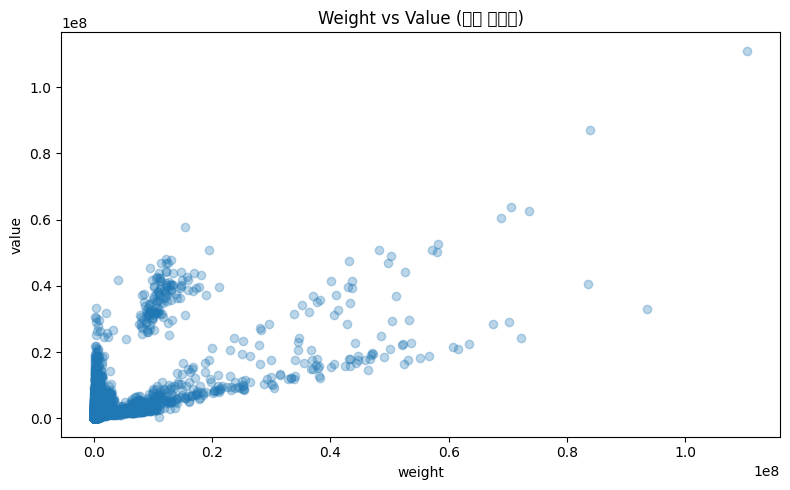

In [4]:
# 1. 전체 weight vs value 산점도
plt.figure(figsize=(8, 5))
plt.scatter(df["weight"], df["value"], alpha=0.3)
plt.xlabel("weight")
plt.ylabel("value")
plt.title("Weight vs Value (전체 산점도)")
plt.tight_layout()
plt.show()

- 그래프 해석
    - 대부분의 점들이 0 근처(작은 무게 or 작은 금액)에 몰려 있고 아주 큰 값이 일부만 존재
    - 극단값 일부가 분포를 끌고 가는 heavy-tailed 구조
    - log 변환으로 분포를 변환한다.

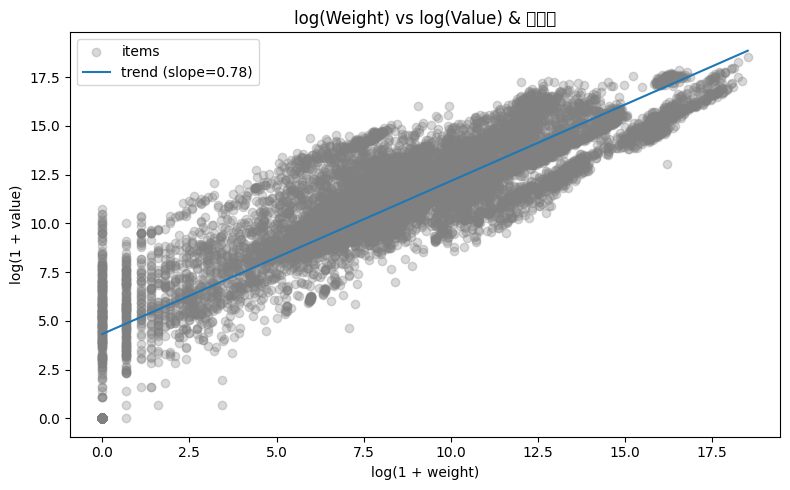

In [5]:
# 2. log(1+weight) vs log(1+value) 산점도 + 추세선
w_log = np.log1p(df["weight"].values)
v_log = np.log1p(df["value"].values)

# 선형 회귀 (log-log 관계)
coef = np.polyfit(w_log, v_log, 1)
line_x = np.linspace(w_log.min(), w_log.max(), 100)
line_y = coef[0] * line_x + coef[1]

plt.figure(figsize=(8, 5))
plt.scatter(w_log, v_log, alpha=0.3, label="items", color='gray')
plt.plot(line_x, line_y, label=f"trend (slope={coef[0]:.2f})")
plt.xlabel("log(1 + weight)")
plt.ylabel("log(1 + value)")
plt.title("log(Weight) vs log(Value) & 추세선")
plt.legend()
plt.tight_layout()
plt.show()

- 그래프 해석
    - 선형에 가까운 모양이며 양의 회귀선을 가짐
    - 전체적으로는 무게가 증가하면 무역량이 증가함
    - 다만, 회귀선 주변으로 퍼진 정도가 크기 때문에 품목별로 편차가 큼

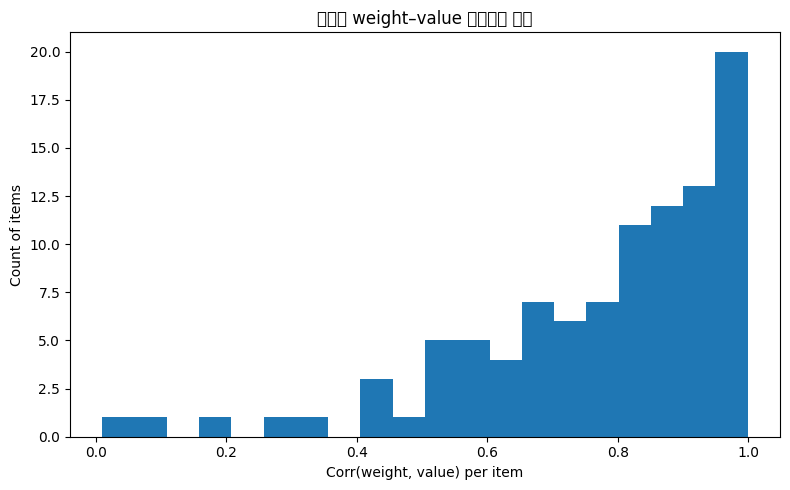

상관계수 요약 통계
count    99.000000
mean      0.774769
std       0.208101
min       0.010139
25%       0.667753
50%       0.832088
75%       0.937690
max       0.999316
dtype: float64


In [6]:
# 3. 품목(item_id)별 weight–value 상관계수 계산
def item_corr(group):
    # 상수열이면 corr 계산 안 되므로 예외 처리
    if group["weight"].nunique() <= 1 or group["value"].nunique() <= 1:
        return np.nan
    return group["weight"].corr(group["value"])

item_corr_series = df.groupby("item_id").apply(item_corr)

# 3-1. 상관계수 분포 히스토그램
valid_corr = item_corr_series.dropna()

plt.figure(figsize=(8, 5))
plt.hist(valid_corr, bins=20)
plt.xlabel("Corr(weight, value) per item")
plt.ylabel("Count of items")
plt.title("품목별 weight–value 상관계수 분포")
plt.tight_layout()
plt.show()

print("상관계수 요약 통계")
print(valid_corr.describe())

- 그래프 해석
    - 양의 상관이 높은 품목이 많고
    - 0에 가깝거나 전혀 상관없는 것 같은 값도 존재
    - 무게에 영향을 받는 품목과 아닌 품목을 다르게 연산하는 것이 가능성 있는 방법일지도

In [7]:
# 4. 품목별 요약 통계 + 클러스터링 (mean_weight, mean_value, corr_wv)

summary = df.groupby("item_id").agg(
    mean_weight=("weight", "mean"),
    mean_value=("value", "mean")
).reset_index()

summary = summary.merge(
    item_corr_series.rename("corr_wv").reset_index(),
    on="item_id",
    how="left"
)

# NaN 상관계수는 0으로 대체
summary["corr_wv"] = summary["corr_wv"].fillna(0.0)

# 클러스터링용 특징
X = summary[["mean_weight", "mean_value", "corr_wv"]].copy()
X = X.replace([np.inf, -np.inf], 0).fillna(0)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# K-means 클러스터링 (k=3은 필요에 따라 조정)
kmeans = KMeans(n_clusters=3, n_init=10, random_state=42)
labels = kmeans.fit_predict(X_scaled)
summary["cluster"] = labels

print("클러스터별 아이템 수")
print(summary["cluster"].value_counts())

클러스터별 아이템 수
cluster
1    73
0    25
2     2
Name: count, dtype: int64


  File "c:\Project\data-contest-lab\.venv\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "C:\Python\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "C:\Python\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Python\lib\subprocess.py", line 1440, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


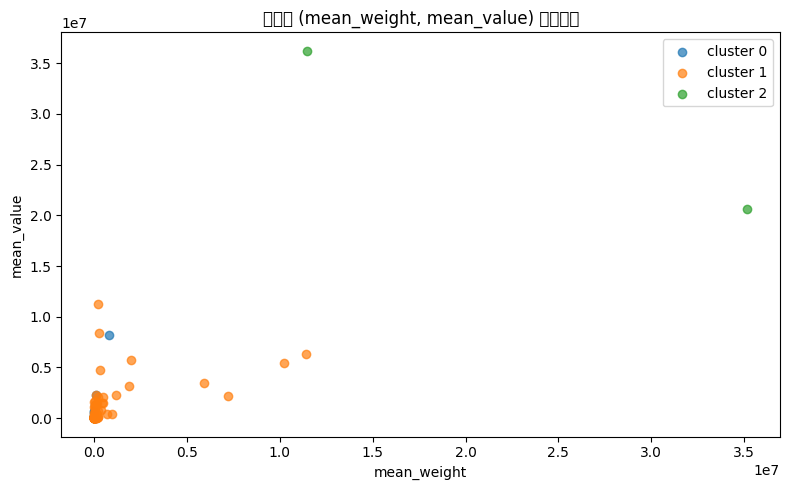

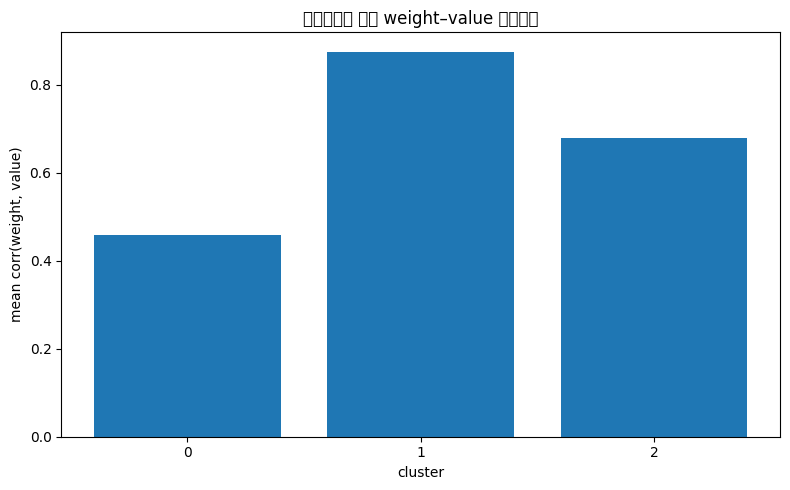

클러스터별 corr_wv 평균
cluster
0    0.458747
1    0.875019
2    0.678528
Name: corr_wv, dtype: float64


In [8]:
# 4-1. 클러스터별 (mean_weight, mean_value) 산점도
plt.figure(figsize=(8, 5))
for cl in sorted(summary["cluster"].unique()):
    sub = summary[summary["cluster"] == cl]
    plt.scatter(sub["mean_weight"], sub["mean_value"], alpha=0.7, label=f"cluster {cl}")
plt.xlabel("mean_weight")
plt.ylabel("mean_value")
plt.title("품목별 (mean_weight, mean_value) 클러스터")
plt.legend()
plt.tight_layout()
plt.show()

# 4-2. 클러스터별 corr_wv 평균 막대 그래프
cluster_corr_means = summary.groupby("cluster")["corr_wv"].mean()

plt.figure(figsize=(8, 5))
plt.bar(cluster_corr_means.index.astype(str), cluster_corr_means.values)
plt.xlabel("cluster")
plt.ylabel("mean corr(weight, value)")
plt.title("클러스터별 평균 weight–value 상관계수")
plt.tight_layout()
plt.show()

print("클러스터별 corr_wv 평균")
print(cluster_corr_means)

- 그래프 해석
    - Cluster 1
        - 평균 무게, 무역량 둘 다 높은 품목들
        - corr_wv도 상대적으로 높음
        -> 무겁고 비싼 품목 그룹일 가능성이 높음
    - Cluster 2
        - 평균 무게가 중간 이하
        - corr_wv 값도 중간 정도
        -> 부분적으로 무게의 영향을 받는 그룹
    - Cluster 0
        - 평균 무게, 무역량이 작거나 특이한 품목들
        - corr_wv 평균이 낮거나 거의 0
        -> 무게에 거의 영향을 받지 않는 그룹

=== weight-driven top10 품목 (corr_wv 기준) ===
    item_id   mean_weight    mean_value   corr_wv
0  GIKPEWTY  8.745875e+03  1.180762e+04  0.999316
1  XIIEJNEE  4.744654e+03  7.435752e+04  0.999309
2  AANGBULD  1.135188e+05  6.451359e+04  0.998196
3  FTSVTTSR  1.158562e+05  6.354788e+04  0.995796
4  XMKRPGLB  9.703977e+05  3.781706e+05  0.994608
5  ANWUJOKX  2.837111e+04  1.946161e+04  0.992166
6  PYZMVUWD  1.369212e+03  8.031864e+03  0.989813
7  OGAFEHLU  4.028251e+04  1.081357e+06  0.988890
8  IGDVVKUD  6.753034e+02  6.816910e+03  0.987433
9  SDWAYPIK  5.904829e+06  3.449991e+06  0.977132

시계열 플롯을 그릴 대표 품목: ['GIKPEWTY', 'XIIEJNEE', 'AANGBULD', 'FTSVTTSR', 'XMKRPGLB']


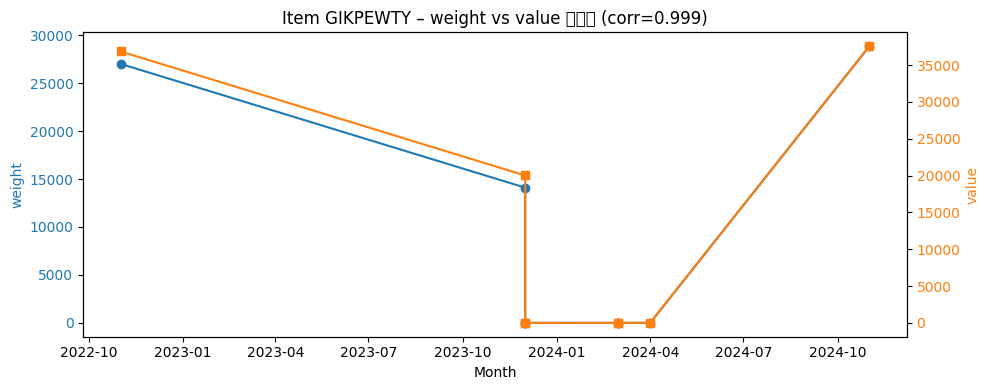

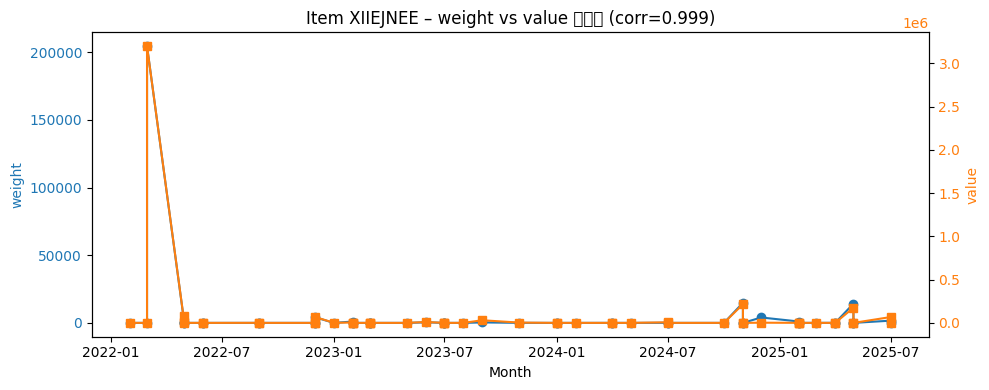

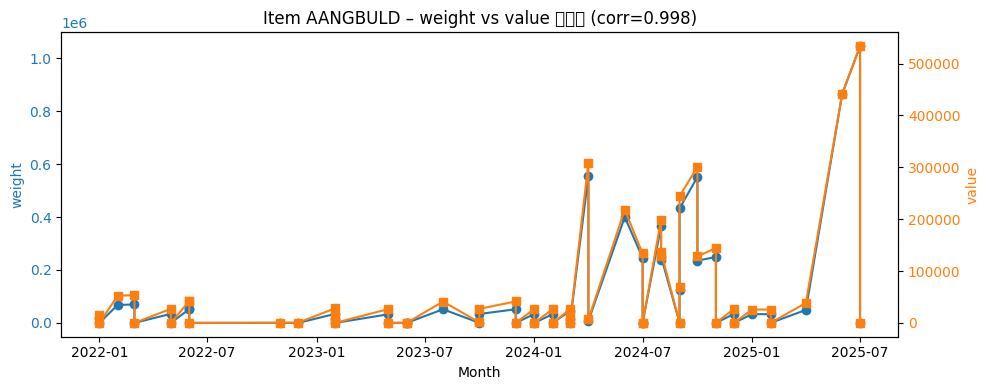

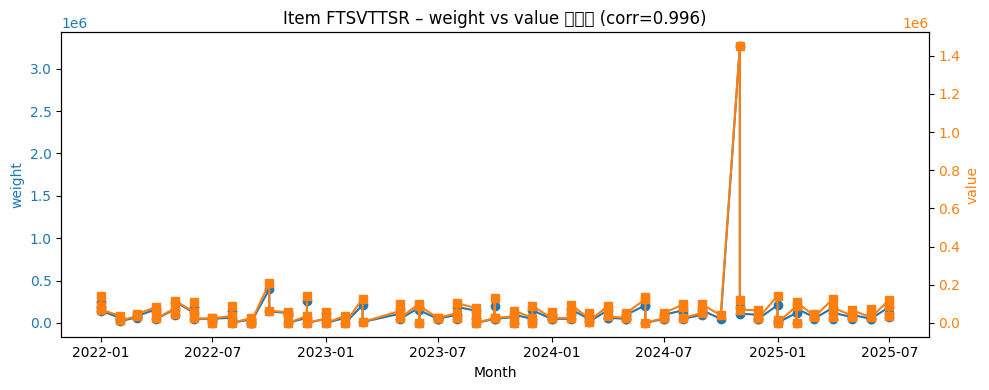

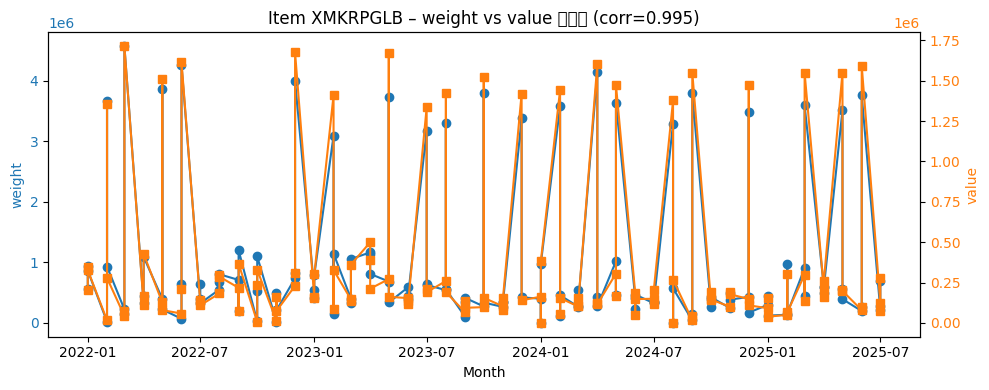

In [9]:
# 날짜 컬럼 만들어 두면 시계열 그리기 편함
df["ym"] = pd.to_datetime(df["year"].astype(str) + "-" + df["month"].astype(str) + "-01")

# 1. item별 weight–value 상관계수 계산
def item_corr(group):
    if group["weight"].nunique() <= 1 or group["value"].nunique() <= 1:
        return np.nan
    return group["weight"].corr(group["value"])

item_corr_series = df.groupby("item_id").apply(item_corr)

# 2. summary 만들기 (mean_weight, mean_value, corr_wv)
summary = df.groupby("item_id").agg(
    mean_weight=("weight", "mean"),
    mean_value=("value", "mean")
).reset_index()

summary = summary.merge(
    item_corr_series.rename("corr_wv").reset_index(),
    on="item_id",
    how="left"
)

# corr_wv가 NaN인 경우는 일단 0으로 처리
summary["corr_wv"] = summary["corr_wv"].fillna(0.0)

# 3. weight-driven 상위 10개 item 추출 (corr_wv 기준 내림차순)
top10 = summary.sort_values("corr_wv", ascending=False).head(10).reset_index(drop=True)

print("=== weight-driven top10 품목 (corr_wv 기준) ===")
print(top10[["item_id", "mean_weight", "mean_value", "corr_wv"]])

# 4. 이 중에서 대표 item 몇 개 골라 시계열 플롯
#    필요하면 n_representatives 숫자 조절
n_representatives = 5
rep_items = top10["item_id"].head(n_representatives).tolist()

print("\n시계열 플롯을 그릴 대표 품목:", rep_items)

for item in rep_items:
    item_df = (
        df[df["item_id"] == item]
        .sort_values(["year", "month"])
    )

    # x축: 월(ym)
    x = item_df["ym"]
    w = item_df["weight"]
    v = item_df["value"]

    fig, ax1 = plt.subplots(figsize=(10, 4))

    # 왼쪽 y축: weight
    ax1.plot(x, w, marker="o", label="weight", color="tab:blue")
    ax1.set_xlabel("Month")
    ax1.set_ylabel("weight", color="tab:blue")
    ax1.tick_params(axis="y", labelcolor="tab:blue")

    # 오른쪽 y축: value
    ax2 = ax1.twinx()
    ax2.plot(x, v, marker="s", label="value", color="tab:orange")
    ax2.set_ylabel("value", color="tab:orange")
    ax2.tick_params(axis="y", labelcolor="tab:orange")

    # 제목에 item_id와 corr_wv 함께 표시
    corr_val = float(top10[top10["item_id"] == item]["corr_wv"])
    plt.title(f"Item {item} – weight vs value 시계열 (corr={corr_val:.3f})")

    fig.tight_layout()
    plt.show()

# 3. 무게 기반 / 논 기반 데이터 빌드

In [10]:
def nmae(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true))

In [11]:
# ============================================================
# 1) Weight-driven / Non-weight-driven 그룹 분리 기준 만들기
# ============================================================

# item별 corr(weight, value) 계산
def item_corr(g):
    if g["weight"].nunique() <= 1 or g["value"].nunique() <= 1:
        return np.nan
    return g["weight"].corr(g["value"])

item_corr_series = df.groupby("item_id").apply(item_corr).fillna(0)

summary = df.groupby("item_id").agg(
    mean_weight=("weight", "mean"),
    mean_value=("value", "mean")
).reset_index()

summary = summary.merge(
    item_corr_series.rename("corr_wv").reset_index(),
    on="item_id",
    how="left"
)

# 그룹 기준: 하위 30% / 상위 30%
q_low = summary["corr_wv"].quantile(0.3)
q_high = summary["corr_wv"].quantile(0.7)

def classify_group(c):
    if c >= q_high:
        return "weight_driven"
    elif c <= q_low:
        return "non_weight"
    else:
        return "middle"

summary["weight_group"] = summary["corr_wv"].apply(classify_group)

# item_id → group 매핑
group_map = summary.set_index("item_id")["weight_group"].to_dict()

print(summary["weight_group"].value_counts())

weight_group
middle           40
weight_driven    30
non_weight       30
Name: count, dtype: int64


In [12]:
# pivot_value: item_id × ym 형태의 value pivot
# pivot_weight: item_id × ym 형태의 weight pivot
# pairs_bestlag: leader–follower 공행성 정보 (leading_item_id, following_item_id, best_lag)
# group_map: item_id → ["weight_driven", "non_weight", "middle"]

def make_pivot(df):
    # 연월 컬럼 생성
    df = df.copy()
    df["ym"] = pd.to_datetime(
        df["year"].astype(str) + "-" + df["month"].astype(str) + "-01"
    )

    # (item_id, ym) 기준으로 합치기: 같은 달에 여러 row 있는 것들 묶어서 sum
    grouped = df.groupby(["item_id", "ym"], as_index=False).agg(
        value=("value", "sum"),
        weight=("weight", "sum")
    )

    # 이제 중복이 없으니 pivot 가능
    pivot_value = grouped.pivot(index="item_id", columns="ym", values="value").sort_index()
    pivot_weight = grouped.pivot(index="item_id", columns="ym", values="weight").sort_index()

    return pivot_value, pivot_weight

def build_pairs_bestlag(pivot_value, max_lag=6, corr_threshold=0.0):
    """
    pivot_value: item × month value 매트릭스
    각 (leader, follower) 쌍에 대해 lag 1~max_lag 중
    follower(t) vs leader(t-lag) 피어슨 상관계수 최대가 되는 lag를 찾음.
    corr_threshold 이상인 쌍만 남김(기본은 필터 안 함).
    """
    items = pivot_value.index.tolist()
    values = pivot_value.values  # shape: (n_items, n_months)
    n_items, n_months = values.shape

    rows = []

    for i, leader in enumerate(items):
        a = values[i]  # leader 시계열
        for j, follower in enumerate(items):
            if i == j:
                continue
            b = values[j]  # follower 시계열

            best_lag = None
            best_corr = 0.0

            for lag in range(1, max_lag + 1):
                # follower(t) vs leader(t-lag)
                if n_months - lag <= 1:
                    continue

                x = a[:-lag]        # leader(선행)
                y = b[lag:]         # follower(후행)

                if np.all(x == x[0]) or np.all(y == y[0]):
                    continue

                c = np.corrcoef(x, y)[0, 1]
                if np.isnan(c):
                    continue

                # 절대값 기준으로 제일 큰 lag 선택
                if abs(c) > abs(best_corr):
                    best_corr = c
                    best_lag = lag

            if best_lag is None:
                continue

            if abs(best_corr) >= corr_threshold:
                rows.append({
                    "leading_item_id": leader,
                    "following_item_id": follower,
                    "best_lag": best_lag,
                    "max_corr": best_corr
                })

    return pd.DataFrame(rows)

In [13]:
pivot_value, pivot_weight = make_pivot(df)

pairs_bestlag = build_pairs_bestlag(pivot_value, max_lag=6, corr_threshold=0.2)
print(pairs_bestlag.shape)
print(pairs_bestlag.head())

(3487, 4)
  leading_item_id following_item_id  best_lag  max_corr
0        AHMDUILJ          ATLDMDBO         4  0.483281
1        AHMDUILJ          BEZYMBBT         4  0.319341
2        AHMDUILJ          BJALXPFS         5 -0.298863
3        AHMDUILJ          BSRMSVTC         1 -0.389717
4        AHMDUILJ          BTMOEMEP         1  0.353165


In [14]:
# ============================================================
# 1) Weight-driven 그룹 dataset builder
# ============================================================

def A_build_dataset_weight_group(pivot_value, pivot_weight, pairs_bestlag, group_map):
    """
    weight-driven 그룹 전용 dataset builder
    follower 중심 supervised table 생성
    """

    records = []

    for _, row in pairs_bestlag.iterrows():
        leader = row["leading_item_id"]
        follower = row["following_item_id"]
        lag = int(row["best_lag"])

        if group_map.get(follower, "middle") != "weight_driven":
            continue  # weight-driven follower만

        if follower not in pivot_value.index or leader not in pivot_value.index:
            continue

        v_f = pivot_value.loc[follower]
        w_f = pivot_weight.loc[follower]
        v_l = pivot_value.loc[leader]
        w_l = pivot_weight.loc[leader]

        for t in range(lag + 2, len(v_f) - 1):  
            # follower 현재시점 t, target = follower value at t+1

            record = {
                "follower": follower,
                "leader": leader,
                "t_idx": t,
                "ym": v_f.index[t],
                
                # follower value/weight series
                "value_t": v_f.iloc[t],
                "value_t_1": v_f.iloc[t-1],
                "value_t_2": v_f.iloc[t-2],
                "value_diff": v_f.iloc[t] - v_f.iloc[t-1],
                "value_growth": (v_f.iloc[t] - v_f.iloc[t-1]) / (v_f.iloc[t-1] + 1),

                "weight_t": w_f.iloc[t],
                "weight_t_1": w_f.iloc[t-1],
                "weight_t_2": w_f.iloc[t-2],
                "weight_diff": w_f.iloc[t] - w_f.iloc[t-1],
                "weight_growth": (w_f.iloc[t] - w_f.iloc[t-1]) / (w_f.iloc[t-1] + 1),

                # unit price
                "unit_price_t": v_f.iloc[t] / (w_f.iloc[t] + 1),

                # leader (lag)
                "leader_weight_lag": w_l.iloc[t-lag],
                "leader_value_lag": v_l.iloc[t-lag],

                # target
                "target": v_f.iloc[t+1],

                "group": "weight_driven"
            }

            records.append(record)

    return # pd.DataFrame(records)

In [15]:
# ============================================================
# 2) Non-weight-driven 그룹 dataset builder
# ============================================================

def build_dataset_nonweight_group(pivot_value, pivot_weight, pairs_bestlag, group_map):
    records = []
    for _, row in pairs_bestlag.iterrows():
        leader = row["leading_item_id"]
        follower = row["following_item_id"]
        lag = int(row["best_lag"])

        if group_map.get(follower) != "non_weight":
            continue

        if leader not in pivot_value.index or follower not in pivot_value.index:
            continue

        v_f = pivot_value.loc[follower]
        v_l = pivot_value.loc[leader]

        for t in range(lag+3, len(v_f)-1):
            rec = {
                "follower": follower,
                "leader": leader,
                "t_idx": t,
                "value_t": v_f.iloc[t],
                "value_t_1": v_f.iloc[t-1],
                "value_t_2": v_f.iloc[t-2],
                "value_t_3": v_f.iloc[t-3],
                "value_diff": v_f.iloc[t] - v_f.iloc[t-1],
                "value_growth": (v_f.iloc[t] - v_f.iloc[t-1]) / (v_f.iloc[t-1] + 1),
                "leader_value_lag": v_l.iloc[t-lag],
                "leader_value_diff": v_l.iloc[t-lag] - v_l.iloc[t-lag-1],
                "leader_value_growth": (v_l.iloc[t-lag] - v_l.iloc[t-lag-1]) / (v_l.iloc[t-lag-1] + 1),
                "best_lag": lag,
                "target": v_f.iloc[t+1],
                "group": "non_weight"
            }
            records.append(rec)

    return pd.DataFrame(records)

In [16]:
def build_dataset_weight_group(pivot_value, pivot_weight, pairs_bestlag, group_map):
    records = []

    for _, row in pairs_bestlag.iterrows():
        leader = row["leading_item_id"]
        follower = row["following_item_id"]
        lag = int(row["best_lag"])
        strength = abs(row["max_corr"])

        if group_map.get(follower) != "weight_driven":
            continue

        if leader not in pivot_value.index or follower not in pivot_value.index:
            continue

        v_f = pivot_value.loc[follower]
        w_f = pivot_weight.loc[follower]
        v_l = pivot_value.loc[leader]
        w_l = pivot_weight.loc[leader]

        for t in range(lag+6, len(v_f)-1):

            rec = {
                "follower": follower,
                "leader": leader,
                "t_idx": t,

                # follower basic
                "value_t": v_f.iloc[t],
                "value_t_1": v_f.iloc[t-1],
                "value_t_2": v_f.iloc[t-2],

                "weight_t": w_f.iloc[t],
                "weight_t_1": w_f.iloc[t-1],
                "weight_t_2": w_f.iloc[t-2],

                # NEW: lag 3
                "value_t_3": v_f.iloc[t-3],
                "weight_t_3": w_f.iloc[t-3],

                # leader lag (그대로)
                "leader_value_lag": v_l.iloc[t-lag],
                "leader_weight_lag": w_l.iloc[t-lag],

                # leader signal strength
                "leader_strength": strength,

                # target
                "target": v_f.iloc[t+1],
                "group": "weight_driven"
            }

            records.append(rec)

    return pd.DataFrame(records)


In [17]:
# ============================================================
# 6) Build final datasets
# ============================================================
df_w = build_dataset_weight_group(pivot_value, pivot_weight, pairs_bestlag, group_map)
df_n = build_dataset_nonweight_group(pivot_value, pivot_weight, pairs_bestlag, group_map)

print("df_w:", df_w.shape)
print("df_n:", df_n.shape)

df_w: (28723, 16)
df_n: (38815, 15)


In [18]:
from catboost import CatBoostRegressor

In [19]:
# ============================================================
# 7) Train/Valid split (공통)
# ============================================================
t_max = max(df_w["t_idx"].max(), df_n["t_idx"].max())
valid_border = t_max - 2  # 마지막 3개월 valid

# Weight-driven
train_w = df_w[df_w["t_idx"] <= valid_border]
valid_w = df_w[df_w["t_idx"] > valid_border]

# Non-weight
train_n = df_n[df_n["t_idx"] <= valid_border]
valid_n = df_n[df_n["t_idx"] > valid_border]


# ============================================================
# 8) Train models
# ============================================================
model_w = CatBoostRegressor(iterations=800, depth=8, learning_rate=0.03, loss_function="MAE", verbose=100)
model_n = CatBoostRegressor(iterations=800, depth=8, learning_rate=0.03, loss_function="MAE", verbose=100)

feature_w = [c for c in train_w.columns if c not in ["target","follower","leader","group","t_idx","ym"]]
feature_n = [c for c in train_n.columns if c not in ["target","follower","leader","group","t_idx","ym"]]

model_w.fit(train_w[feature_w], train_w["target"])
model_n.fit(train_n[feature_n], train_n["target"])


# ============================================================
# 9) NMAE 평가
# ============================================================
pred_w = model_w.predict(valid_w[feature_w])
pred_n = model_n.predict(valid_n[feature_n])

print("Weight-driven NMAE:", nmae(valid_w["target"], pred_w))
print("Non-weight-driven NMAE:", nmae(valid_n["target"], pred_n))

0:	learn: 2456075.0037863	total: 154ms	remaining: 2m 2s
100:	learn: 687930.4472925	total: 926ms	remaining: 6.41s
200:	learn: 510713.1931889	total: 1.76s	remaining: 5.26s
300:	learn: 381416.2453485	total: 2.55s	remaining: 4.23s
400:	learn: 298592.6709688	total: 3.28s	remaining: 3.27s
500:	learn: 273047.0811681	total: 4.03s	remaining: 2.4s
600:	learn: 228578.5796370	total: 4.83s	remaining: 1.6s
700:	learn: 192869.8941700	total: 5.6s	remaining: 791ms
799:	learn: 167166.3890531	total: 6.36s	remaining: 0us
0:	learn: 7149804.3641254	total: 8.74ms	remaining: 6.99s
100:	learn: 1212971.1837538	total: 775ms	remaining: 5.36s
200:	learn: 861760.3833483	total: 1.52s	remaining: 4.55s
300:	learn: 694152.8248033	total: 2.35s	remaining: 3.9s
400:	learn: 647877.5419229	total: 3.09s	remaining: 3.07s
500:	learn: 545985.6918170	total: 3.85s	remaining: 2.3s
600:	learn: 494489.5051476	total: 4.6s	remaining: 1.52s
700:	learn: 468044.9440638	total: 5.36s	remaining: 757ms
799:	learn: 385143.0780898	total: 6.18s

In [20]:
# item-wise weight-value correlation
item_corr = (
    df.groupby("item_id")[["weight", "value"]]
      .corr()
      .unstack()
      .iloc[:,1]
      .dropna()
)

# ✔ strong weight-driven item list
strong_items = item_corr[item_corr > 0.85].index.tolist()
len(strong_items), strong_items[:10]

(45,
 ['AANGBULD',
  'AHMDUILJ',
  'ANWUJOKX',
  'APQGTRMF',
  'AXULOHBQ',
  'BEZYMBBT',
  'BTMOEMEP',
  'BUZIIBYG',
  'CCLHWFWF',
  'DDEXPPXU'])

In [21]:
pairs_strong = pairs_bestlag[pairs_bestlag["following_item_id"].isin(strong_items)].copy()
pairs_strong.shape

(1417, 4)

In [22]:
print(pairs_bestlag.columns.tolist())
print(sub.columns.tolist())

['leading_item_id', 'following_item_id', 'best_lag', 'max_corr']
['item_id', 'mean_weight', 'mean_value', 'corr_wv', 'cluster']


In [25]:
feature_w = model_w.feature_names_
feature_n = model_n.feature_names_

In [28]:
# ---------------------------------------------------------
# 1. 그룹 분리: corr(weight, value) 기반
# ---------------------------------------------------------
# item별 상관계수 계산
item_corr = (
    df.groupby("item_id")[["weight", "value"]]
      .corr()
      .unstack()
      .iloc[:, 1]
      .fillna(0.0)
)

# weight-driven: 상위 30%
q_high = item_corr.quantile(0.7)

group_map = {}
for item, c in item_corr.items():
    if c >= q_high:
        group_map[item] = "weight_driven"
    else:
        group_map[item] = "non_weight"   # 나머지 다 non

# ---------------------------------------------------------
# 2. pivot value/weight 생성
# ---------------------------------------------------------
df["ym"] = pd.to_datetime(df["year"].astype(str) + "-" + df["month"].astype(str) + "-01")

grouped = df.groupby(["item_id", "ym"], as_index=False).agg(
    value=("value", "sum"),
    weight=("weight", "sum")
)

pivot_value  = grouped.pivot(index="item_id", columns="ym", values="value").sort_index()
pivot_weight = grouped.pivot(index="item_id", columns="ym", values="weight").sort_index()

# ---------------------------------------------------------
# 3. pairs_bestlag 생성 (corr_threshold=0.2)
# ---------------------------------------------------------
def build_pairs_bestlag(pivot_value, max_lag=6, corr_threshold=0.2):
    items = pivot_value.index.tolist()
    values = pivot_value.values
    n_items, n_months = values.shape

    rows = []
    for i, leader in enumerate(items):
        a = values[i]
        for j, follower in enumerate(items):
            if i == j:
                continue
            b = values[j]

            best_lag = None
            best_corr = 0.0

            for lag in range(1, max_lag+1):
                if n_months - lag <= 1:
                    continue
                x = a[:-lag]
                y = b[lag:]

                if np.all(x == x[0]) or np.all(y == y[0]):
                    continue

                c = np.corrcoef(x, y)[0,1]
                if np.isnan(c):
                    continue

                if abs(c) > abs(best_corr):
                    best_corr = c
                    best_lag = lag

            if best_lag is None:
                continue

            if abs(best_corr) >= corr_threshold:
                rows.append({
                    "leading_item_id": leader,
                    "following_item_id": follower,
                    "best_lag": best_lag,
                    "max_corr": best_corr
                })

    return pd.DataFrame(rows)


pairs_bestlag = build_pairs_bestlag(pivot_value, max_lag=6, corr_threshold=0.2)

# ---------------------------------------------------------
# 4. submission 템플릿 생성 → threshold 0.3 이상만 대상
# ---------------------------------------------------------
pairs_for_sub = pairs_bestlag[pairs_bestlag["max_corr"] >= 0.3].copy()

sub = pairs_for_sub[["leading_item_id", "following_item_id", "best_lag", "max_corr"]].copy()
sub["value"] = 0.0

# ---------------------------------------------------------
# 5. inference feature builder (weight-driven / non-weight-driven)
# ---------------------------------------------------------

def make_features_weight(follower, leader, lag, pv, pw):
    # follower/leader 존재 여부 체크
    if follower not in pv.index or leader not in pv.index:
        return None

    v_f = pv.loc[follower]
    w_f = pw.loc[follower]
    v_l = pv.loc[leader]
    w_l = pw.loc[leader]

    t = len(v_f) - 1
    if t < 3 or t - lag < 0:
        return None

    # follower value
    value_t   = v_f.iloc[t]
    value_t_1 = v_f.iloc[t-1]
    value_t_2 = v_f.iloc[t-2]
    value_t_3 = v_f.iloc[t-3]

    # follower weight
    weight_t   = w_f.iloc[t]
    weight_t_1 = w_f.iloc[t-1]
    weight_t_2 = w_f.iloc[t-2]
    weight_t_3 = w_f.iloc[t-3]

    # leader lagged
    leader_value_lag  = v_l.iloc[t - lag]
    leader_weight_lag = w_l.iloc[t - lag]

    # leader_strength = leader_value_lag * leader_weight_lag
    leader_strength = leader_value_lag * leader_weight_lag

    return pd.DataFrame([{
        "value_t": value_t,
        "value_t_1": value_t_1,
        "value_t_2": value_t_2,
        "value_t_3": value_t_3,
        "weight_t": weight_t,
        "weight_t_1": weight_t_1,
        "weight_t_2": weight_t_2,
        "weight_t_3": weight_t_3,
        "leader_value_lag": leader_value_lag,
        "leader_weight_lag": leader_weight_lag,
        "leader_strength": leader_strength,
    }])


def make_features_nonweight(follower, leader, lag, pv):
    if follower not in pv.index or leader not in pv.index:
        return None

    v_f = pv.loc[follower]
    v_l = pv.loc[leader]

    t = len(v_f) - 1
    if t < 3 or t - lag < 1:
        return None

    value_t   = v_f.iloc[t]
    value_t_1 = v_f.iloc[t-1]
    value_t_2 = v_f.iloc[t-2]
    value_t_3 = v_f.iloc[t-3]

    value_diff   = value_t - value_t_1
    value_growth = (value_diff) / (value_t_1 + 1)

    leader_value_lag   = v_l.iloc[t - lag]
    leader_value_lag_1 = v_l.iloc[t - lag - 1]
    leader_value_diff  = leader_value_lag - leader_value_lag_1
    leader_value_growth = (leader_value_diff) / (leader_value_lag_1 + 1)

    return pd.DataFrame([{
        "value_t": value_t,
        "value_t_1": value_t_1,
        "value_t_2": value_t_2,
        "value_t_3": value_t_3,
        "value_diff": value_diff,
        "value_growth": value_growth,
        "leader_value_lag": leader_value_lag,
        "leader_value_diff": leader_value_diff,
        "leader_value_growth": leader_value_growth,
        "best_lag": lag,
    }])


# ---------------------------------------------------------
# 6. inference
# ---------------------------------------------------------

def to_int(v):
    return int(round(max(v, 0)))

preds = []

for idx, row in sub.iterrows():
    follower = row["following_item_id"]
    leader   = row["leading_item_id"]
    lag      = int(row["best_lag"])
    corr     = row["max_corr"]

    # corr < 0.3 → fallback
    if abs(corr) < 0.3:
        preds.append(pivot_value.loc[follower].iloc[-1])
        continue

    # 그룹 선택
    group = group_map.get(follower, "non_weight")

    if group == "weight_driven":
        feat = make_features_weight(follower, leader, lag, pivot_value, pivot_weight)
        if feat is None:
            p = pivot_value.loc[follower].iloc[-1]
        else:
            p = model_w.predict(feat[feature_w])[0]
    else:
        feat = make_features_nonweight(follower, leader, lag, pivot_value)
        if feat is None:
            p = pivot_value.loc[follower].iloc[-1]
        else:
            p = model_n.predict(feat[feature_n])[0]

    preds.append(to_int(p))

sub["value"] = preds

# ---------------------------------------------------------
# 7. 저장
# ---------------------------------------------------------
sub[["leading_item_id", "following_item_id", "value"]].to_csv(
    "submission_final_corr0p3_splitgroups.csv",
    index=False
)

print("Saved: submission_final_corr0p3_splitgroups.csv")

Saved: submission_final_corr0p3_splitgroups.csv
